In [10]:
import numpy as np
from numpy import random
import math
import pandas as pd
import matplotlib.pyplot as plt

In [32]:
def predicted_real(predicted, real):
    plt.scatter(real, predicted, c='blue')
    p1 = max(max(predicted), max(real))
    p2 = min(min(predicted), min(real))
    plt.plot([p1, p2], [p1, p2], 'b-')
    plt.xlabel('True values')
    plt.ylabel('Predictions')
    plt.title('Predictions visualization on test set')
    plt.axis('equal')
    plt.show()

In [11]:
def sigmoid(x):
    """Funkcja sigmoidalna"""
    return 1/(1 + math.exp(-x))
sigmoid = np.vectorize(sigmoid)

In [12]:
def sigmoid_der(x):
    """Pochodna funkcji sigmoidalnej"""
    return sigmoid(x)*(1-sigmoid(x))
sigmoid_der = np.vectorize(sigmoid_der)

In [13]:
def MSE(predicted, real):
    return np.mean((predicted - real)**2)

In [14]:
def MAE(predicted, real):
    return np.mean(np.abs(predicted - real))

In [16]:
#Funkcje pmocnicze
def normalize(x):
    return (x - np.min(x)) / (np.max(x) - np.min(x))

def prepear_data(df_train, df_test):
    #Separacja wektorów cech i odpowiedzi
    x_train, x_test = df_train.iloc[:, 1], df_test.iloc[:, 1]
    x_train, x_test = np.array(x_train), np.array(x_test)
    #Implementacja wymaga "pionowego" wektora cech
    x_train.shape = (len(x_train), 1)
    x_test.shape = (len(x_test), 1)
    y_train, y_test = np.array(df_train.iloc[:, 2:3]), np.array(df_test.iloc[:, 2:3])
    #Normalizacja
    x_train, x_test = normalize(x_train), normalize(x_test)
    y_train, y_test = normalize(y_train), normalize(y_test)
    return x_train, y_train, x_test, y_test

In [18]:
###ZMIANY
# - wektoryzacja funkcji pomocniczych przy definiowaniu
# - oddzielne metody Network predict i forward
# - oddzielne metody predict i forward w Layer
#   (z lub bez obłożenia funkcją aktywacji)

In [180]:
class Layer:
        
    def __init__(self, 
                 #Liczba neuronów w poprzedzającej i kolejnej warstwie
                 input_size: int, 
                 output_size: int,
                 #Domyślna funkcja aktywacyjna i jej pochodna                 
                 activation_fun = sigmoid, 
                 activation_fun_der = sigmoid_der,
                 #Parametry rozkładu jednostajnego dla losowych wag
                 lb = -1,
                 ub = 1,
                 #Możliwe do ustawienia wagi i bias-y
                 weights = None, 
                 biases = None):
        
        #Domyślne losowo wygenerowane wagi i bias-y jeśli nie zostały podane
        d_weights = random.uniform(lb, ub, size = (input_size, output_size))
        d_biases = random.uniform(lb, ub, size = (1, output_size))
        
        #Wagi dla wszystkich neuronów z warstwy 
        self.weights = weights if weights is not None else d_weights
        
        #Stałe "b"
        self.biases = biases if biases is not None else d_biases
        
        #Funkcja aktywacji i jej pochodna
        self.activation_fun = activation_fun
        self.activation_fun_der = activation_fun_der
    
    def predict(self, input):
        #Przekształca input z poprzedniej warstwy przez wagi i funkcję aktywacji 
        #Zwraca output do przekazania kolejnej warstwie
        return self.activation_fun(input @ self.weights + self.biases)
    
    def forward(self, input):
        #Przekształca input z poprzedniej warstwy jedynie przez wagi
        return input @ self.weights + self.biases

In [150]:
class Network:
    
    def __init__(self, layers: list):
        
        #Warstwy
        self.layers = layers
        
    def predict(self, X):
        """Oblicza output na podstawie danych i parametrów warstw"""
        output = X
        for layer in self.layers:
            output = layer.predict(output)
        return output
    
    def forward(self, X):
        """Pełna metoda feedforward
        return: sumy, aktywacje"""
        sums = []
        activations = [X]
        activations_layer = X
        for layer in self.layers:
            sums_layer = layer.forward(activations_layer)
            sums.append(sums_layer)
            
            activations_layer = layer.activation_fun(sums_layer)
            activations.append(activations_layer)
            
        return sums, activations
    
    def backprop(self, X, Y):
        """Propagacja wsteczna błędu
        return: gradienty MSE"""
        
        #Wyliczenie feedforward obecnymi parametrami
        sums, activations = self.forward(X)
        
        #Macierze na poprawki parametrów
        delta_biases = [np.zeros(l.biases.shape) for l in self.layers]
        delta_weights = [np.zeros(l.weights.shape) for l in self.layers]
        
        #Wyliczenie err ostatniej warstwy
        err = (activations[-1] - Y)*self.layers[-1].activation_fun_der(sums[-1])
        
        #Wyliczenie gradientu MSE po parametrach ostatniej warstwy
        delta_biases[-1] = err
        delta_weights[-1] = activations[-2].transpose()@err
        
        #Propagacja wsteczna
        n_layers = len(self.layers)
        
        for i in range(n_layers-2, -1, -1):
            act_f_der = self.layers[i].activation_fun_der(sums[i])
            err = (err@self.layers[i+1].weights.transpose()) * act_f_der 
            delta_biases[i] = err
            delta_weights[i] = np.dot(activations[i-1].transpose(), err)
        
        return delta_biases, delta_weights
    
    def train(self, X, Y, k = 1, etha = 0.001, tol = 0.001, verbose = False):
        """Wytrenowuje sieć wybraną metodą minimalizując MSE 
        na zbiorze walidacyjnym"""
        
        etha = etha/len(X)
        
        if(k==1):
            algorithm = self.gd
        else:
            algorithm = self.batch_gd
        
        #Losowość przed podziałem zbioru, ziarno zapewnia identyczną permutację
        #w zmiennych objaśnających i zmiennej celu
        random.RandomState(42).shuffle(X)
        random.RandomState(42).shuffle(Y)
        
        #Podział zbioru na część walidacyjną i treningową
        #proporcje: val 20% - train 80%
        X_split = np.split(X, [int(.8 * len(X))])
        X_train, X_val = X_split[0], X_split[1]
        
        Y_split = np.split(Y, [int(.8 * len(Y))])
        Y_train, Y_val = Y_split[0], Y_split[1]
        
        #Właściwe trenowanie sieci
        current_mse = np.inf
        new_mse = MSE(self.predict(X_val), Y_val)
        it = 1
        while True:
            #Wywołanie konkretnego algorytmu
            algorithm(X_train, Y_train, k, etha)
            new_mse = MSE(self.predict(X_val), Y_val)
            
            #Wizualizacja procesu uczenia
            if(verbose):
                print("Current MSE on validation set:")
                print(new_mse)
                for i in range(len(self.layers)):
                    print("Epoche " + str(it) + " finished")
                    print("Warstwa " + str(i) + " wagi:")
                    print(self.layers[i].weights)
                    print("Warstwa " + str(i) + " bias-y:")
                    print(self.layers[i].biases)
                print("\n")
            
            it += 1
            if(current_mse - new_mse > tol):
                current_mse = new_mse
            else:
                break
                
        print("Final MSE on validation set:")
        print(current_mse)
        return
    
    def gd(self, X, Y, k, etha):
        """Trening sieci podstawową metodą Gradient Descent"""
        delta_biases = [np.zeros(l.biases.shape) for l in self.layers]
        delta_weights = [np.zeros(l.weights.shape) for l in self.layers]
        
        for x, y in zip(X, Y):
            b, w = self.backprop(x, y)
            delta_biases = [cb-etha*nb for cb, nb in zip(delta_biases, b)]
            delta_weights = [cw-etha*nw for cw, nw in zip(delta_weights, w)]
        
        for i in range(len(self.layers)):
            l = self.layers[i]
            l.biases = l.biases + delta_biases[i]
            l.weights = l.weights + delta_weights[i]
        return
    
    def batch_gd(self, X, Y, k, etha):
        """Trening sieci metodą Mini-batch Gradient Descent"""
        #Metoda train uprzednio dokonuje permutacji zbioru
        #Wystarczy podzielić go na batche
        X_split = np.array_split(X, k)
        Y_split = np.array_split(Y, k)
        
        #Wywołanie metody gradient descent na kolejnych batch-ach
        for i in range(k):
            self.gd(X_split[i], Y_split[i], k, etha)
        return
        

In [127]:
df1_train = pd.read_csv("./mio1/regression/steps-small-training.csv")
df1_test = pd.read_csv("./mio1/regression/steps-small-test.csv")
x_train, y_train, x_test, y_test = prepear_data(df1_train, df1_test)

In [110]:
#Utworzenie warst z dobranymi parametrami
l1 = Layer(input_size=1, output_size=5, 
           weights=np.array([[0.75, -0.8, 0.4, -0.7, 0.4]]), 
           biases=np.array([[-1, -0.9, -0.9, -1, 0.2]]))
          
l2 = Layer(input_size=5, output_size=1, 
           activation_fun= lambda x: x, 
           activation_fun_der= lambda x: 1,
           weights = np.array([[40], [40], [35], [35], [0]]),
           biases = np.array([[-41.25]]))
          

#Konstrukcja obiektu sieci i predykcja na danych treningowych i testowych
mlp = Network([l1, l2])
#pred_train = mlp.forward(x_train)
#pred_test = mlp.forward(x_test)

In [176]:
#Utworzenie warst z dobranymi parametrami
l1 = Layer(input_size=1, output_size=5)
#l2 = Layer(input_size=5, output_size=5)
#l3 = Layer(input_size=5, output_size=5)
l4 = Layer(input_size=5, output_size=1, 
           activation_fun= lambda x: x, 
           activation_fun_der= lambda x: 1)          

#Konstrukcja obiektu sieci i predykcja na danych treningowych i testowych
#mlp = Network([l1, l2, l3, l4])
mlp = Network([l1, l4])
#pred_train = mlp.forward(x_train)
#pred_test = mlp.forward(x_test)

In [162]:
#Architektura: 1 warstwa (10 neuronów) losowe parametry
l1 = Layer(1, 10)
l2 = Layer(10, 1, activation_fun= lambda x: x)

mlp = Network([l1, l2])

In [177]:
mlp.train(x_train, y_train, k=5, etha=10**(-2))

Final MSE on validation set:
0.051052430634319065


In [178]:
pred_test = mlp.predict(x_test)
print(MSE(pred_test, y_test))

0.20029388231027942


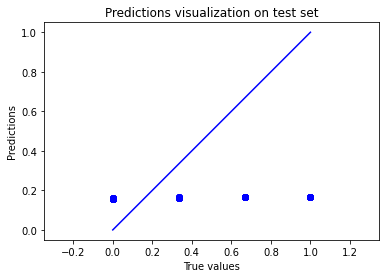

In [179]:
predicted_real(pred_test, y_test)